# Setup

In [557]:
import pandas as pd
import numpy as np

## Download the Data

In [558]:
housing = pd.read_csv('https://raw.githubusercontent.com/Osman-Dawood/IAI600-Lab2/refs/heads/main/housing.csv')

## Create a Test Set

In [559]:
 # set income category based on median income
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [560]:
from sklearn.model_selection import StratifiedShuffleSplit
    # stratified sampling
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    # get train and test dataset
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Prepare the Data for Machine Learning Algorithms:

1. Dropping the Target Variable

2. Creating Labels

Feature Set (housing): This DataFrame will be used as the input features for training the machine learning model.

Labels (housing_labels): This Series will be used as the target variable that the model will learn to predict.

In [561]:
# Dropping the Target Variable
housing_tr= strat_train_set.drop("median_house_value", axis=1)
# Creates a copy of the selected column to avoid modifying the original DataFrame.
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning
Most machine learning algorithms cannot work with missing features. For example, we noticed earlier that the total_bedrooms
attribute has some missing values.

#In the book 3 options for solution are listed:
```python
housing.dropna(subset=["total_bedrooms"])    # option 1: Get rid of the corresponding districts.
housing.drop("total_bedrooms", axis=1)       # option 2: Get rid of the whole attribute.
median = housing["total_bedrooms"].median()  # option 3: Set the missing values to some value (zero, the mean, the median, etc.). This is called imputation
housing["total_bedrooms"].fillna(median, inplace=True)


We go for option 3 since it is the least destructive, but instead of the
preceding code, we will use a handy Scikit-Learn class: SimpleImputer to find the median of the total_bedrooms, which will be used automatically in the following Transformation Pipelines.

Now remove the text attribute (ocean_proximity) because median can only be calculated on numerical attributes:

In [562]:
housing_num = housing_tr.drop("ocean_proximity", axis=1)

Let's create a custom transformer to add extra attributes:



In [563]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformation Pipelines



ColumnTransformer can transform  the numerical attributes & category/text attributes both together

In [564]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
     ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder()),
    ])
full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', cat_pipeline, cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_tr)

In [565]:
housing_prepared.shape

(16512, 17)

# Select and Train a Model

## Training and Evaluating on the Training Set

Linear Regression

In [566]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lin_reg = LinearRegression()

# training by fitting inputs and outputs
lin_reg.fit(housing_prepared, housing_labels)

# Prediction error
housing_predictions = lin_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
rmse = np.sqrt(mse)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
some_data = housing_tr.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Compare
print("\n  Predictions:", list(lin_reg.predict(some_data_prepared).round(-2)))
print("  Labels:     ", list(some_labels.round(-2)))



  Prediction RMSE error in : 67815.61655105946

  Predictions: [180200.0, 156700.0, 107500.0, 351200.0, 166900.0]
  Labels:      [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]


Decision Tree Regressor

In [567]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)

# training by fitting inputs and outputs
tree_reg.fit(housing_prepared, housing_labels)

# Prediction error
housing_predictions = tree_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
rmse = np.sqrt(mse)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
some_data = housing_tr.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Compare
print("\n  Predictions:", list(tree_reg.predict(some_data_prepared).round(-2)))
print("  Labels:     ", list(some_labels.round(-2)))


  Prediction RMSE error in : 0.0

  Predictions: [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]
  Labels:      [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]


This model gave zero prediction error, so either it is absolutely perfector it badly overfitted the data which is more likely.To be sure  we use  





This model gave zero prediction error, so either it is absolutely perfector it badly overfitted the data which is more likely.To be sure  we use Cross-Validation technique.





## Better Evaluation Using Cross-Validation

In [568]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [569]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [71754.39700636 67826.46551675 70523.2774544  71051.59739052
 72667.29052315 68953.276044   67655.42303425 72262.81056809
 71013.83896093 66377.11736207]
Mean: 70008.54938605212
Standard deviation: 2053.3308814942884


The decision tree has an RMSE of about 69907 when cv=10 used (the training set split into 10 nonoverlapping subsets called folds, then it trains and evaluates the decision tree model 10 times, picking a different fold for evaluation every time and using the other 9 folds for training).

Using Cross-Validation with the previous Linear Regression model

In [570]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69190.53416178 66420.79322463 67997.84059038 72169.33079522
 67928.19837154 67401.4978209  66240.69391457 67694.84830544
 67828.61900541 67484.24315304]
Mean: 68035.65993429087
Standard deviation: 1585.20931189741


Random Forest Regressor

In [571]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

# Prediction error
housing_predictions = forest_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
rmse = np.sqrt(mse)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
some_data = housing_tr.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Compare
print("\n  Predictions:", list(forest_reg.predict(some_data_prepared).round(-2)))
print("  Labels:     ", list(some_labels.round(-2)))


  Prediction RMSE error in : 18685.28707998014

  Predictions: [144600.0, 147600.0, 77900.0, 391400.0, 140300.0]
  Labels:      [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]


The Random Forest Regressor has a RMSE of  18685 which is much lower, meaning that there’s still quite alot of overfitting going on.

Cross-Validation with the previous Random
Forest Regressor

In [572]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51515.02341353 47842.19465139 48449.21009759 51154.32029753
 51863.96236256 51201.91831795 50327.43517532 49622.47478138
 49627.68487174 49232.83598767]
Mean: 50083.70599566528
Standard deviation: 1285.0921831892194


Support Vector Regression SVR

In [573]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

# Prediction error
housing_predictions = svm_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, housing_predictions)
rmse = np.sqrt(mse)
print("\n  Prediction RMSE error in :", rmse)

# let's try the full preprocessing pipeline on a few training instance
some_data = housing_tr.iloc[:5].round(-2)
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
# Compare
print("\n  Predictions:", list(svm_reg.predict(some_data_prepared).round(-2)))
print("  Labels:     ", list(some_labels.round(-2)))


  Prediction RMSE error in : 106385.05123428142

  Predictions: [195900.0, 180600.0, 187200.0, 207800.0, 182700.0]
  Labels:      [124900.0, 152800.0, 70200.0, 404300.0, 133500.0]


The Random Forest model has an RMSE of about 50083.7 when cv=10 used, and still lowest among all the other three models as shown in the gragh below.



Model training Errors

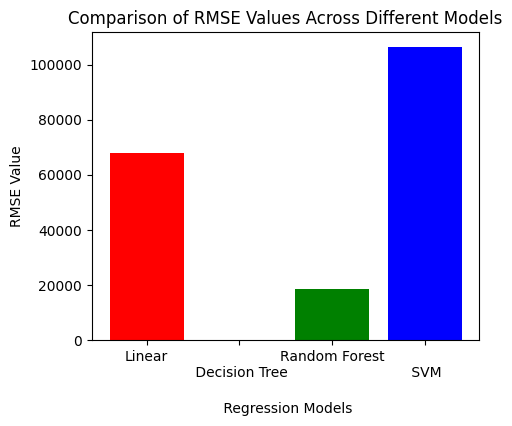

In [574]:
import matplotlib.pyplot as plt

models = ['Linear', '\n Decision Tree', 'Random Forest', '\n SVM']
rmse_values = [67815.6, 0, 18685.3,  106385]
colors = ['red', 'orange', 'green', 'blue' ]

plt.figure(figsize=(5, 4))
plt.bar(models, rmse_values, color=colors)

plt.ylabel('RMSE Value')
plt.xlabel('\n Regression Models')
plt.title('Comparison of RMSE Values Across Different Models')
plt.show()

 After Using Cross-Validation (Validation Errors)

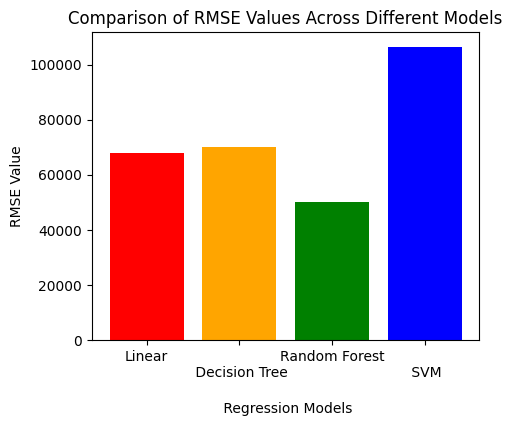

In [575]:
import matplotlib.pyplot as plt

models = ['Linear', '\n Decision Tree', 'Random Forest', '\n SVM']
rmse_values = [68035.6, 70008.5, 50083.7,  106385]
colors = ['red', 'orange', 'green', 'blue' ]

plt.figure(figsize=(5, 4))
plt.bar(models, rmse_values, color=colors)

plt.ylabel('RMSE Value')
plt.xlabel('\n Regression Models')
plt.title('Comparison of RMSE Values Across Different Models')
plt.show()

Among all the four ML models used the random forests look very promising for this task!